<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
A neural ODE toy model
</div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import timeit
from torch.distributions import Normal, Independent, kl_divergence, MultivariateNormal
from torchdiffeq import odeint, odeint_adjoint
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Data
</div>

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 16px; color: black; font-weight: bold;">
Ground truth
</div>

In [4]:
class SpiralFlow(nn.Module):
    """
    Defines the gradient flow of the 2D Spiral as a nn.Module to be used in odeint_adjoint from torchdiffeq
    Inputs:
        - t (scalar tensor): time. Here, the flow is time-invariant, so t is not used. However it is required by the ODE solver.
        - x (tensor of shape (2,)): current position in the 2D plane.
        - mu (float): parameter of the spiral.
    Outputs:
        - x_dot (tensor of shape (2,)): time derivative of the position.
    """
    def __init__(self, mu=0.01):
        super(SpiralFlow, self).__init__()
        self.mu = mu

    def forward(self, t, x):
        x1, x2 = x[0], x[1]
        r  = x1**2 + x2**2
        x1_dot = self.mu * x1 - x2 - x1 * r
        x2_dot = x1 + self.mu * x2 - x2 * r
        return torch.stack([x1_dot, x2_dot])
    
spiral_flow = SpiralFlow().to(device)

x = torch.tensor([2., 0.], device=device, requires_grad=True)
t = torch.tensor([10.], device=device)
dx = spiral_flow(t, x)
print(dx)

tensor([-7.9800,  2.0000], device='cuda:0', grad_fn=<StackBackward0>)


Trajectory parameters

In [5]:
# starting point
x0 = torch.tensor([2.0, 0.0], dtype=torch.float, requires_grad=True).to(device)

# number of points in the trajectory
n_steps = 100

# time span
# t_0 = 0.0  # time of the latent prior z0
t_start = 0.0
t_end = 20.0
ts = torch.linspace(t_start, t_end, n_steps).to(device)

In [6]:
# compute the trajectory
gt_trajectory = odeint_adjoint(spiral_flow, x0, ts, rtol=1e-2, atol=1e-2, method='rk4')

# compute gradients along the trajectory
gradients = []
x = x0.detach().to(device)

for t,x in zip(ts, gt_trajectory):
    gradients.append(spiral_flow(t,x).detach().cpu().numpy())
    
gt_gradients = torch.tensor(np.array(gradients)).to(device)

In [7]:
def plot_trajectory_2D(ts, trajectory, gradients, sampled_ts=None, sampled_trajectory=None, sampled_gradients=None, interval=5, scale=5.0, title="2D Trajectory"):
    """
    Plot the trajectory and the vector field.
    Inputs:
        ground truth:
        - ts (tensor of shape (n_steps,)): time points.
        - trajectory (tensor of shape (n_steps, 2)): trajectory points.
        - gradients (tensor of shape (n_steps, 2)): gradients at each trajectory point.
        sampled points (optional):
        - sampled_ts (tensor of shape (n_sampled,)): sampled time points.
        - sampled_trajectory (tensor of shape (n_sampled, 2)): sampled trajectory points.
        - sampled_gradients (tensor of shape (n_sampled, 2)): gradients
        visualization parameters:
        - interval (int): interval for quiver plot.
        - scale (float): scale for quiver plot.
        - title (str): title of the plot.
    Outputs:
        - fig, ax: matplotlib figure and axis.
    """
    fig, ax = plt.subplots(figsize=(6,6))

    X,Y = trajectory[:,0].detach().cpu().numpy(), trajectory[:,1].detach().cpu().numpy()
    U,V = gradients[:,0].detach().cpu().numpy(), gradients[:,1].detach().cpu().numpy()

    if sampled_trajectory is not None and sampled_gradients is not None:
        X_s, Y_s = sampled_trajectory[:,0].detach().cpu().numpy(), sampled_trajectory[:,1].detach().cpu().numpy()
        U_s, V_s = sampled_gradients[:,0].detach().cpu().numpy(), sampled_gradients[:,1].detach().cpu().numpy()
        s = [50.0] * len(X_s)  # Set a fixed size for all points
        ax.scatter(X_s, Y_s, color='b', marker='x', s=s, label='Sampled Trajectory')
        ax.quiver(X_s, Y_s, U_s, V_s, angles='xy', scale_units='xy', scale=scale, color='b', alpha=0.5, label='Sampled Vector Field')
    
    ax.plot(X,Y, label='GT Trajectory', alpha=0.2, marker='.')
    ax.plot(X[0], Y[0], 'go', label='Start', alpha=0.5)
    ax.plot(X[-1], Y[-1], 'ro', label='End', alpha=0.5)
    ax.quiver(X[::interval], Y[::interval], U[::interval], V[::interval], angles='xy', scale_units='xy', scale=scale, alpha=0.2, label='GT Vector Field')
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    
    return fig, ax

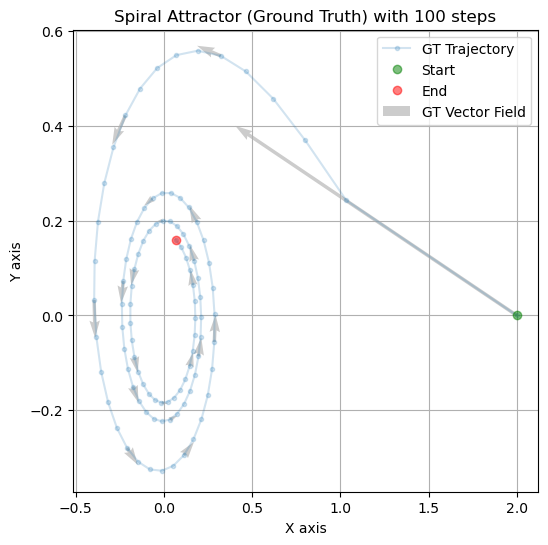

In [8]:
fig, ax = plot_trajectory_2D(ts, gt_trajectory, gt_gradients, title=f"Spiral Attractor (Ground Truth) with {n_steps} steps")

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 16px; color: black; font-weight: bold;">
Create data batch by adding noise and sampling random points from the ground truth trajectory
</div>

In [9]:
# create batch data of noisy samples of ground truth trajectory
batch_size = 512

batch_ts = ts.unsqueeze(0).repeat((batch_size,1))
batch_gt_trajectory = gt_trajectory.unsqueeze(0).repeat((batch_size,1,1))
batch_gt_gradients = gt_gradients.unsqueeze(0).repeat((batch_size,1,1))

# ratio of points to sample from the entire trajectory
ratio = 0.50
n_points = int(ratio * n_steps)

# indices to pick : (batch_size, n_points) array of indices
idx = [ np.sort(np.random.choice(n_steps, size=n_points, replace=False)) for _ in range(batch_size) ]
indices = np.array(idx)

# sample subset of points in the GT trajectory and gradients and form a batch
indices = torch.from_numpy(indices).long().to(ts.device)
batch_sampled_ts = ts[indices]
batch_sampled_trajectory = gt_trajectory[indices]
batch_sampled_gradients = gt_gradients[indices]

# add noise to the sampled points
noise_level = 0.025
noise = noise_level * torch.randn_like(batch_sampled_trajectory)
batch_sampled_noisy_trajectory = batch_sampled_trajectory + noise

In [10]:
# check dimensions

print(f"batch_ts shape: {batch_ts.shape}")
print(f"batch_gt_trajectory shape: {batch_gt_trajectory.shape}")
print(f"batch_gt_gradients shape: {batch_gt_gradients.shape}")
print(f"batch_sampled_ts shape: {batch_sampled_ts.shape}")
print(f"batch_sampled_trajectory shape: {batch_sampled_trajectory.shape}")
print(f"batch_sampled_noisy_trajectory shape: {batch_sampled_noisy_trajectory.shape}")
print(f"batch_sampled_gradients shape: {batch_sampled_gradients.shape}")

batch_ts shape: torch.Size([512, 100])
batch_gt_trajectory shape: torch.Size([512, 100, 2])
batch_gt_gradients shape: torch.Size([512, 100, 2])
batch_sampled_ts shape: torch.Size([512, 50])
batch_sampled_trajectory shape: torch.Size([512, 50, 2])
batch_sampled_noisy_trajectory shape: torch.Size([512, 50, 2])
batch_sampled_gradients shape: torch.Size([512, 50, 2])


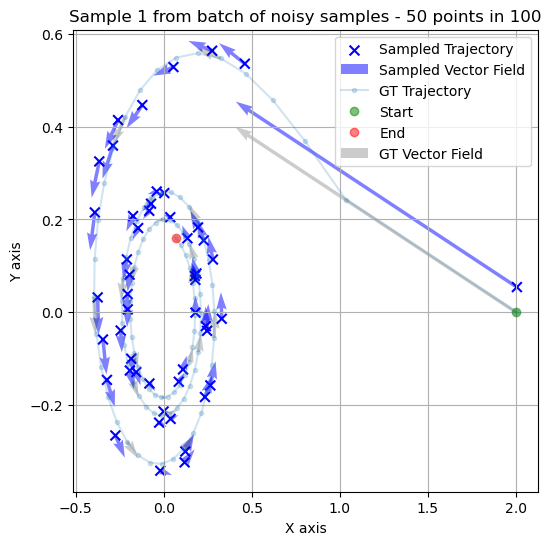

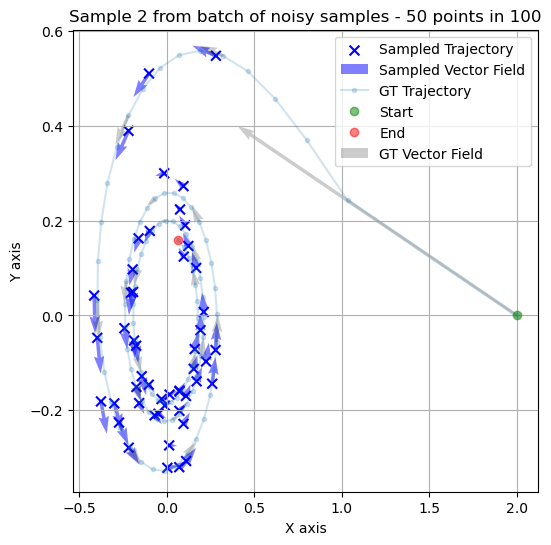

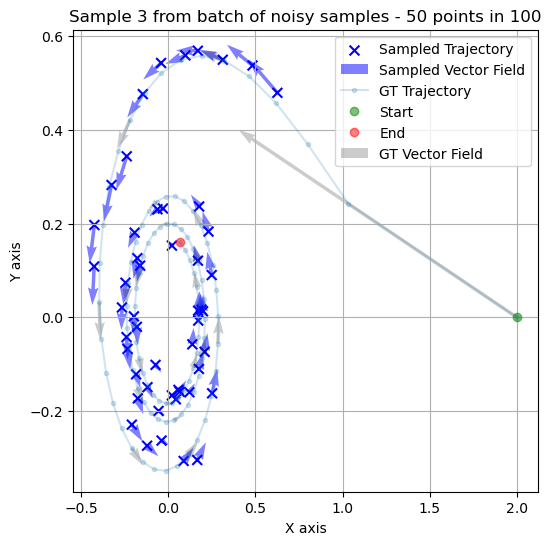

In [11]:
# display some samples
N = 3

for i in range(N):
    fig, ax = plot_trajectory_2D(batch_ts[i], batch_gt_trajectory[i], batch_gt_gradients[i], 
                                 batch_sampled_ts[i], batch_sampled_noisy_trajectory[i], batch_sampled_gradients[i], 
                                 title=f"Sample {i+1} from batch of noisy samples - {n_points} points in {n_steps}")
    plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Model - Step by step pipeline
</div>

from: [ArviX Latent ODEs for Irregularly-Sampled Time Series](https://arxiv.org/abs/1907.03907)

We want to learn the flow dynamics from the batch sampled data

![Alt text](/home/benjamin/Folders_Python/MVA_Stage/images/Neural_ODE_01.png)

Computing the ELBO:

Data is $x_{t_0}, x_{t_2},...,x_{t_N}$.

Model:
\begin{align}
    z_{t_0} = z_0 &\sim \mathcal{N}(0,1) \\
    z_1, z_2, ..., z_N &= \text{ODESolve}(z_0, f_{\theta}, t_0, ..., t_N) \\
    x_i \vert z_i &\sim \mathcal{N}(\mu_{\theta_x}(z_i), \text{diag}\, \sigma_x(z_i)) \\
    q_\phi(z_0 \vert x_{0:N}) &= \mathcal{N}(\mu_\phi(x_{0:N}), \text{diag} \, \sigma_\phi(x_{0:N})) \\
    [ \mu_\phi, \sigma_\phi ](x_{0:N}) &= \text{RNN} \, (x_{0:N}, t_{0:N})
\end{align}

ELBO:
\begin{align}
    p(x_{0:N}) &= \frac{p(x_{0:N}, z_{0:N})}{p(z_{0:N} \vert x_{0:N})} \\
    \log{p(x_{0:N})} &= \mathbb{E}_{q_{\phi}(z_0 \vert x_{0:N})} \log{\frac{p(x_{0:N}, z_{0:N})}{q_{\phi}(z_0 \vert x_{0:N})}\frac{q_{\phi}(z_0 \vert x_{0:N})}{p(z_{0:N} \vert x_{0:N})}} \\
    &= \mathbb{E}_{q_{\phi}(z_0 \vert x_{0:N})} \log{\frac{p(x_{0:N}, z_{0:N})}{q_{\phi}(z_0 \vert x_{0:N})}} + \mathbb{KL}(q_{\phi}(z_0 \vert x_{0:N}) \vert\vert p(z_{0:N} \vert x_{0:N}) ) \\
    &\geq \mathcal{L}(x_{0:N}, \theta, \phi) = \mathbb{E}_{q_{\phi}(z_0 \vert x_{0:N})} \log{\frac{p(x_{0:N}, z_{0:N})}{q_{\phi}(z_0 \vert x_{0:N})}} \\
    \mathcal{L}(x_{0:N}, \theta, \phi) &= \mathbb{E}_{q_{\phi}(z_0 \vert x_{0:N})} \log{\frac{\prod_{i=0}^{n}p_{\theta_x}(x_i \vert z_i) p(z_0)}{q_{\phi}(z_0 \vert x_{0:N})}} \\
    &= \sum_{i=0}^{n} \mathbb{E}_{q_{\phi}(z_0 \vert x_{0:N})} \log{p_{\theta_x}(x_i \vert z_i)} - \mathbb{KL}(q_{\phi}(z_0 \vert x_{0:N}) \vert\vert p(z_0))
\end{align}

Parameters

In [12]:
Dx = 2  # dimension of the data
Dz = 8  # dimension of the latent space

Data

In [13]:
# we have created above, a batch of batch_size samples of n_points taken randmomly
# in the ground truth trajectory of n_steps points,
# and added some noise to the sampled points

x = batch_sampled_noisy_trajectory
print(f"Data x: {x.shape}")
print(f"\tBatch size: {x.shape[0]}")
print(f"\tNumber of sampled points: {x.shape[1]}")
print(f"\tData dimension: {x.shape[2]} (should be {Dx})")

Data x: torch.Size([512, 50, 2])
	Batch size: 512
	Number of sampled points: 50
	Data dimension: 2 (should be 2)


Prior

In [14]:
# in the model, the only stochastic prior variable is z0, the latent state at time t_start
# the random variable z0 has prior p(z0) = N(0, I)

p_theta_z = MultivariateNormal(torch.zeros(Dz).to(device), torch.eye(Dz).to(device))

# we sample one z0 for each element in the batch
z0_samples = p_theta_z.sample((batch_size,))

print(f"Priors z0 : {z0_samples.shape}")

Priors z0 : torch.Size([512, 8])


In [15]:
# the latent variables z1 to z_{n_points} are computed deterministically from z0 and the time points
# with the ODE defined below with a neural net.

# here is the flow neural net for the latent ODE
# it is assumed to be time-invariant, so t is not used in the forward pass
class LatentODEFunc(nn.Module):
    """
    Defines the latent ODE to compute deterministically the latent variables from z0 and the times steps.
    Inputs:
        - Dz (int): dimension of the latent space.
        - hidden_dim (int): dimension of the hidden layers.
        - n_layers (int): number of hidden layers.
    Outputs:
        - z_dot (tensor of shape (batch_size, Dz)): time derivative of the latent variable.
    """
    def __init__(self, Dz, hidden_dim=32, n_layers=1):
        super(LatentODEFunc, self).__init__()
        
        layers = []
        self.n_layers = n_layers
        self.Dz = Dz
        self.hidden_dim = hidden_dim
        input_size = Dz
        for i in range(n_layers):
            layers.append(nn.Linear(input_size, hidden_dim))
            layers.append(nn.Tanh())
            input_size = hidden_dim
        layers.append(nn.Linear(hidden_dim, Dz))  # output mean and logvar
        self.net = nn.Sequential(*layers)

    def forward(self, t, z):
        # here we assume time invariance, so t is not used
        return self.net(z)
    
    def __repr__(self):
        msg = f"Flow function for latent ODE - (Dz={Dz}, hidden_dim={self.hidden_dim}, n_layers={self.n_layers})"
        msg += f"\n{self.net}"
        return msg

latent_ode_func = LatentODEFunc(Dz, hidden_dim=64, n_layers=4).to(device)
print(latent_ode_func)

Flow function for latent ODE - (Dz=8, hidden_dim=64, n_layers=4)
Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): Tanh()
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): Tanh()
  (8): Linear(in_features=64, out_features=8, bias=True)
)


In [16]:
# test shape of the flow function for the latent ODE
z = torch.randn((batch_size, Dz)).to(device)
outputs = latent_ode_func(t_start, z)
print(f"Latent ODE function input: {z.shape} (should be ({batch_size}, {Dz}))")
print(f"Latent ODE function output: {outputs.shape} (should be ({batch_size}, {Dz}))")

Latent ODE function input: torch.Size([512, 8]) (should be (512, 8))
Latent ODE function output: torch.Size([512, 8]) (should be (512, 8))


In [17]:
# compute the whole sequence of latent variables z1 to z_{n_points},
# from z0 and the sampled time points,
# with one ODE solve per batch element

# those are the time stamps to use in the bacth
print(batch_sampled_ts.shape)

# run one ODE per batch dimension
for i in range(batch_size):
    # compute sequence of latent variables for this batch element with ODE solver
    z_sample = odeint_adjoint(latent_ode_func, z0_samples[i], batch_sampled_ts[i], rtol=1e-2, atol=1e-2, method='rk4')
    if i == 0:
        z_samples = z_sample.unsqueeze(0)
    else:
        z_samples = torch.cat([z_samples, z_sample.unsqueeze(0)], dim=0)
        
print(f"z_samples: {z_samples.shape}")

print(f"\tBatch size: {z_samples.shape[0]} (should be {batch_size})")
print(f"\tNumber of time points: {z_samples.shape[1]} (should be {n_points})")
print(f"\tLatent dimension: {z_samples.shape[2]} (should be {Dz})")

torch.Size([512, 50])
z_samples: torch.Size([512, 50, 8])
	Batch size: 512 (should be 512)
	Number of time points: 50 (should be 50)
	Latent dimension: 8 (should be 8)


Likelihood \ decoder

In [18]:
# we use a simple Gaussian liklehood with diagonal covariance
#

class Decoder(nn.Module):
    """
    Decoder to map the latent state z to the data space x.
    Inputs:
        - latent_dim (int): dimension of the latent space (Dz).
        - output_dim (int): dimension of the output data (Dx).
        - hidden_dim (int): dimension of the hidden layer.
        - n_layers (int): number of layers in the MLP.
    Outputs:
        - x_recon (tensor of shape (batch_size, seq_len, Dx)): reconstructed data points.
    """
    def __init__(self, latent_dim, output_dim, hidden_dim=32, n_layers=1):
        super(Decoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.Dz = latent_dim
        self.Dx = output_dim
        
        layers = []
        input_dim = latent_dim
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.Tanh())
            input_dim = self.hidden_dim
        layers.append(nn.Linear(hidden_dim, output_dim * 2))  # output mean and logvar
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, z):
        # z: latent states (batch_size, seq_len, latent_size)
        mu_x = self.mlp(z)[:,:,:self.Dx]  # (batch_size, seq_len, output_size)
        logvar_x = self.mlp(z)[:,:,self.Dx:]  # (batch_size, seq_len, output_size)
        return mu_x, logvar_x
    
    def __repr__(self):
        return f"Decoder(latent_dim={self.Dz}, output_dim={self.Dx}, hidden_dim={self.hidden_dim}, n_layers={self.n_layers}) \n {self.mlp}"
    
decoder = Decoder(Dz, Dx, n_layers=4).to(device)
print(decoder)

Decoder(latent_dim=8, output_dim=2, hidden_dim=32, n_layers=4) 
 Sequential(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=4, bias=True)
)


In [19]:
mu_x, logvar_x = decoder(z_samples)

print(f"Inputs to Decoder: z_samples {z_samples.shape}")
print(f"Outputs of Decoder: mu_x {mu_x.shape}, logvar_x {logvar_x.shape}")

Inputs to Decoder: z_samples torch.Size([512, 50, 8])
Outputs of Decoder: mu_x torch.Size([512, 50, 2]), logvar_x torch.Size([512, 50, 2])


In [20]:
sigma_x = torch.exp(0.5 * logvar_x).to(device)

# p_theta_x = MultivariateNormal(mu_x, sigma_x)
p_theta_x = Independent(Normal(mu_x, sigma_x),1)
print(f"p_theta_x: {p_theta_x}")

p_theta_x: Independent(Normal(loc: torch.Size([512, 50, 2]), scale: torch.Size([512, 50, 2])), 1)


In [21]:
# reconstruction loss:
print(f"batch_sampled_noisy_trajectory: {batch_sampled_noisy_trajectory.shape}")

rec_loss = -p_theta_x.log_prob(batch_sampled_noisy_trajectory)
print(f"Reconstruction loss: mean {rec_loss.mean():.4e} of shape {rec_loss.shape}")
print(f"\tBatch size: {rec_loss.shape[0]} (should be {batch_size})")
print(f"\tNumber of sampled points: {rec_loss.shape[1]} (should be {n_points})")

batch_sampled_noisy_trajectory: torch.Size([512, 50, 2])
Reconstruction loss: mean 1.8618e+00 of shape torch.Size([512, 50])
	Batch size: 512 (should be 512)
	Number of sampled points: 50 (should be 50)


Posterior

In [22]:
# the posterior q_phi(z0 | x0:N) is modeled with an RNN encoder
# it is a Gaussian with mean and logvar given by the RNN output at time N
# the forward pass of the RNN takes also as input the sequence of time stamps

class RNNEncoder(nn.Module):
    """
    RNN Encoder to infer the initial latent state z0 from the observed data.
    Inputs:
        - input_dim (int): dimension of the input data (Dx).
        - hidden_dim (int): dimension of the hidden state in the RNN.
        - latent_dim (int): dimension of the latent space (Dz).
        - n_layers (int): number of layers in the RNN.
    Outputs:
        - z0_mean (tensor of shape (batch_size, Dz)): mean of the inferred initial latent state.
        - z0_logvar (tensor of shape (batch_size, Dz)): log-variance of the inferred initial latent state.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim, n_layers=1):
        super(RNNEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.Dx = input_dim
        self.Dz = latent_dim
        # NB : the input size of the RNN is Dx + 1 for the time stamp concatenated to the data point
        self.rnn = nn.LSTM(input_dim + 1, hidden_dim, n_layers, batch_first=True)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, t, x):
        # t: sequence of time stamps (batch_size, seq_len)
        # x: sequence of data points (batch_size, seq_len, input_dim)
        times = t.unsqueeze(-1)  # (batch_size, seq_len, 1)
        x_ext = torch.cat([x, times], dim=-1)  # (batch_size, seq_len, input_dim + 1)
        _, (h_n, c_n) = self.rnn(x_ext)  # h_n: (n_layers, batch_size, hidden_dim)
        h_n = h_n[-1]  # take the last layer's hidden state: (batch_size, hidden_dim)
        z0_mean = self.fc_mean(h_n)  # (batch_size, latent_dim)
        z0_logvar = self.fc_logvar(h_n)  # (batch_size, latent_dim)
        return z0_mean.squeeze(0), z0_logvar.squeeze(0)
    
    def __repr__(self):
        msg = f"RNNEncoder(input_dim={self.Dx} (+1 for time stamps), hidden_dim={self.hidden_dim}, latent_dim={self.Dz}, n_layers={self.n_layers}), \n"
        msg += f"LSTM : {self.rnn}, Mean : {self.fc_mean}, Logvar : {self.fc_logvar}"
        return msg

rnn_encoder = RNNEncoder(input_dim=Dx, hidden_dim=64, latent_dim=Dz, n_layers=4).to(device)
print(rnn_encoder)

RNNEncoder(input_dim=2 (+1 for time stamps), hidden_dim=64, latent_dim=8, n_layers=4), 
LSTM : LSTM(3, 64, num_layers=4, batch_first=True), Mean : Linear(in_features=64, out_features=8, bias=True), Logvar : Linear(in_features=64, out_features=8, bias=True)


In [23]:
z0_mean, z0_logvar = rnn_encoder(batch_sampled_ts, batch_sampled_noisy_trajectory)

print(f"Inputs to RNN Encoder: batch_sampled_ts {batch_sampled_ts.shape}, batch_sampled_trajectory {batch_sampled_noisy_trajectory.shape}")
print(f"outputs of RNN Encoder: z0_mean {z0_mean.shape} z0_logvar {z0_logvar.shape} ")

Inputs to RNN Encoder: batch_sampled_ts torch.Size([512, 50]), batch_sampled_trajectory torch.Size([512, 50, 2])
outputs of RNN Encoder: z0_mean torch.Size([512, 8]) z0_logvar torch.Size([512, 8]) 


In [24]:
mu_phi = z0_mean.to(device)
print(f"mu_phi : {mu_phi.shape}")
sigma_phi = torch.diag_embed(torch.exp(0.5 * z0_logvar).to(device))
print(f"sigma_phi : {sigma_phi.shape}")

q_phi = MultivariateNormal(mu_phi, sigma_phi)
print(f"q_phi: {q_phi}")
print(f"\tbatch shape: {q_phi.batch_shape}, event shape: {q_phi.event_shape}")

z0_samples = q_phi.rsample().to(device).squeeze()
print(f"z0_samples: {z0_samples.shape}")
print(f"\tBatch size: {z0_samples.shape[0]}")
print(f"\tDimension: {z0_samples.shape[1]}")

mu_phi : torch.Size([512, 8])
sigma_phi : torch.Size([512, 8, 8])
q_phi: MultivariateNormal(loc: torch.Size([512, 8]), covariance_matrix: torch.Size([512, 8, 8]))
	batch shape: torch.Size([512]), event shape: torch.Size([8])
z0_samples: torch.Size([512, 8])
	Batch size: 512
	Dimension: 8


In [25]:
kl_loss = kl_divergence(q_phi, p_theta_z).to(device)
print(f"KL loss: mean {kl_loss.mean():.4e} of shape {kl_loss.shape}")

KL loss: mean 1.7505e-02 of shape torch.Size([512])


Total loss

In [26]:
loss = rec_loss.mean() + kl_loss.mean()
print(f"Total loss: {loss.item():.4e}")

Total loss: 1.8793e+00


In [27]:
loss.backward()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Model - Training loop
</div>

In [28]:
# form datasets and dataloaders for PyTorch training
# we store the full times, trajectories and gradients for reference
# but only the sampled noisy trajectories and sampled times are used for training

class SpiralDataset(torch.utils.data.Dataset):
    def __init__(self, t, X, flows, all_t=None, all_X=None, all_flows=None):
        """
        Inputs:
            - all_t (numpy array of shape (n_samples, n_steps)): full time points.
            - all_X (numpy array of shape (n_samples, n_steps, Dx)): full trajectory points.
            - all_flows (numpy array of shape (n_samples, n_steps, Dx)): full gradients points.
            - t (numpy array of shape (n_samples, n_points)): time points of sampled data
            - X (numpy array of shape (n_samples, n_points, Dx)): data points of sampled data
            - flows (numpy array of shape (n_samples, n_points, Dx)): gradients points of sampled data
        """
        self.t = torch.tensor(t, dtype=torch.float32)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.flows = torch.tensor(flows, dtype=torch.float32)
        self.all_t = torch.tensor(all_t, dtype=torch.float32) if all_t is not None else None
        self.all_X = torch.tensor(all_X, dtype=torch.float32) if all_X is not None else None
        self.all_flows = torch.tensor(all_flows, dtype=torch.float32) if all_flows is not None else None

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        return self.t[idx], self.X[idx], self.flows[idx], self.all_t[idx], self.all_X[idx], self.all_flows[idx]
    
# form train and test datasets
train_ratio = 0.80
train_id = int(train_ratio * batch_size)

# train
t_train_all = batch_ts[:train_id].detach().cpu().numpy().reshape(-1, n_steps)
X_train_all = batch_gt_trajectory[:train_id].detach().cpu().numpy().reshape(-1, n_steps, Dx)
flows_train_all = batch_gt_gradients[:train_id].detach().cpu().numpy().reshape(-1, n_steps, Dx)
t_train = batch_sampled_ts[:train_id].detach().cpu().numpy().reshape(-1, n_points)
X_train = batch_sampled_noisy_trajectory[:train_id].detach().cpu().numpy().reshape(-1, n_points, Dx)
flows_train = batch_sampled_gradients[:train_id].detach().cpu().numpy().reshape(-1, n_points, Dx)

# test
t_test_all = batch_ts[train_id:].detach().cpu().numpy().reshape(-1, n_steps)
X_test_all = batch_gt_trajectory[train_id:].detach().cpu().numpy().reshape(-1, n_steps, Dx)
flows_test_all = batch_gt_gradients[train_id:].detach().cpu().numpy().reshape(-1, n_steps, Dx)
t_test = batch_sampled_ts[train_id:].detach().cpu().numpy().reshape(-1, n_points)
X_test = batch_sampled_noisy_trajectory[train_id:].detach().cpu().numpy().reshape(-1, n_points, Dx)
flows_test = batch_sampled_gradients[train_id:].detach().cpu().numpy().reshape(-1, n_points, Dx)

# datasets
train_dataset = SpiralDataset(t_train, X_train, flows_train, t_train_all, X_train_all, flows_train_all)
test_dataset = SpiralDataset(t_test, X_test, flows_test, t_test_all, X_test_all, flows_test_all)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

bs = 32 # batch size for dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)

Train dataset: 409 samples
Test dataset: 103 samples


In [29]:
# hyperparameters
Dx = 2  # dimension of the data
Dz = 4  # dimension of the latent space

# model bricks
# prior
p_theta_z = MultivariateNormal(torch.zeros(Dz).to(device), torch.eye(Dz).to(device))
# latent ODE flow
latent_ode_func = LatentODEFunc(Dz, hidden_dim=64, n_layers=4).to(device)
# decoder
decoder = Decoder(Dz, Dx, n_layers=4).to(device)
# encoder / approximate posterior
rnn_encoder = RNNEncoder(input_dim=Dx, hidden_dim=64, latent_dim=Dz, n_layers=4).to(device)

# report out
print(f"Model components:")
print(f"Prior : {p_theta_z}")
print(f"Latent ODE function : {latent_ode_func}")
print(f"Decoder : {decoder}")
print(f"RNN Encoder : {rnn_encoder}")

# training loop parameters
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    list(rnn_encoder.parameters()) + list(latent_ode_func.parameters()) + list(decoder.parameters()), 
    lr=learning_rate
)

# report out
print(f"Training parameters:")
print(f"Learning rate : {learning_rate}")
print(f"Optimizer : {optimizer}")

Model components:
Prior : MultivariateNormal(loc: torch.Size([4]), covariance_matrix: torch.Size([4, 4]))
Latent ODE function : Flow function for latent ODE - (Dz=4, hidden_dim=64, n_layers=4)
Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): Tanh()
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): Tanh()
  (8): Linear(in_features=64, out_features=4, bias=True)
)
Decoder : Decoder(latent_dim=4, output_dim=2, hidden_dim=32, n_layers=4) 
 Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=4, bias=True)
)
RNN Encoder : RN

In [30]:
# Training step
def train_step(batch_sampled_ts, batch_sampled_noisy_trajectory, optimizer, rnn_encoder, latent_ode_func, decoder):
    """
    Perform one training step (ie one epoch)
    Inputs:
        - batch_sampled_ts (tensor of shape (batch_size, n_points)): batch of time points.
        - batch_sampled_noisy_trajectory (tensor of shape (batch_size, n_points, Dx)): batch of noisy trajectory points.
        - optimizer: optimizer to use.
        - rnn_encoder: RNN encoder model.
        - latent_ode_func: latent ODE function model.
        - decoder: decoder model.
    Outputs:
        - loss (float): total loss (reconstruction + KL).
        - rec_loss (float): reconstruction loss.
        - kl_loss (float): KL divergence loss.
        - rnn_encoder, latent_ode_func, decoder: models in train mode.
    """
    
    # get in train mode
    rnn_encoder.train()
    latent_ode_func.train()
    decoder.train()
    
    # reset gradients
    optimizer.zero_grad()
    
    # encode to get q_phi(z0 | x0:N)
    z0_mean, z0_logvar = rnn_encoder(batch_sampled_ts, batch_sampled_noisy_trajectory)
    mu_phi = z0_mean.to(device)
    sigma_phi = torch.diag_embed(torch.exp(0.5 * z0_logvar).to(device))
    q_phi = MultivariateNormal(mu_phi, sigma_phi)
    
    # sample z0 from q_phi
    z0_samples = q_phi.rsample().to(device).squeeze()
    
    # compute latent trajectory z1:N from z0 and t1:N with latent ODE
    batch_size, n_points = batch_sampled_ts.shape
    for i in range(batch_size):
        z_sample = odeint_adjoint(latent_ode_func, z0_samples[i], batch_sampled_ts[i], rtol=1e-3, atol=1e-3, method='rk4')
        if i == 0:
            z_samples = z_sample.unsqueeze(0)
        else:
            z_samples = torch.cat([z_samples, z_sample.unsqueeze(0)], dim=0)
    
    # decode to get p_theta(x | z)
    mu_x, logvar_x = decoder(z_samples)
    sigma_x = torch.exp(0.5 * logvar_x).to(device)
    p_theta_x = Independent(Normal(mu_x, sigma_x),1)
    
    # reconstruction loss
    rec_loss = -p_theta_x.log_prob(batch_sampled_noisy_trajectory).mean()
    
    # KL loss
    kl_loss = kl_divergence(q_phi, p_theta_z).mean()
    
    # total loss
    loss = rec_loss + kl_loss
    
    # backpropagation
    loss.backward()
    optimizer.step()
    
    return rnn_encoder, latent_ode_func, decoder, loss.item(), rec_loss.item(), kl_loss.item()

In [31]:
# Test step
def test_step(batch_sampled_ts, batch_sampled_noisy_trajectory, rnn_encoder, latent_ode_func, decoder):
    """
    Perform one test step (ie one epoch)
    Inputs:
        - batch_sampled_ts (tensor of shape (batch_size, n_points)): batch of time points.
        - batch_sampled_noisy_trajectory (tensor of shape (batch_size, n_points, Dx)): batch of noisy trajectory points.
        - rnn_encoder: RNN encoder model.
        - latent_ode_func: latent ODE function model.
        - decoder: decoder model.
    Outputs:
        - loss (float): total loss (reconstruction + KL).
        - rec_loss (float): reconstruction loss.
        - kl_loss (float): KL divergence loss.
    """
    
    # get in eval mode
    rnn_encoder.eval()
    latent_ode_func.eval()
    decoder.eval()
    
    with torch.no_grad():
        # encode to get q_phi(z0 | x0:N)
        z0_mean, z0_logvar = rnn_encoder(batch_sampled_ts, batch_sampled_noisy_trajectory)
        mu_phi = z0_mean.to(device)
        sigma_phi = torch.diag_embed(torch.exp(0.5 * z0_logvar).to(device))
        q_phi = MultivariateNormal(mu_phi, sigma_phi)

        # sample z0 from q_phi
        z0_samples = q_phi.rsample().to(device).squeeze()

        # compute latent trajectory z1:N from z0 and t1:N with latent ODE
        batch_size, n_points = batch_sampled_ts.shape
        for i in range(batch_size):
            z_sample = odeint_adjoint(latent_ode_func, z0_samples[i], batch_sampled_ts[i], rtol=1e-3, atol=1e-3, method='rk4')
            if i == 0:
                z_samples = z_sample.unsqueeze(0)
            else:
                z_samples = torch.cat([z_samples, z_sample.unsqueeze(0)], dim=0)

        # decode to get p_theta(x | z)
        mu_x, logvar_x = decoder(z_samples)
        sigma_x = torch.exp(0.5 * logvar_x).to(device)
        p_theta_x = Independent(Normal(mu_x, sigma_x),1)

        # reconstruction loss
        rec_loss = -p_theta_x.log_prob(batch_sampled_noisy_trajectory).mean()
        
        # KL loss
        kl_loss = kl_divergence(q_phi, p_theta_z).mean()
        
        # total loss
        loss = rec_loss + kl_loss
        
    return loss.item(), rec_loss.item(), kl_loss.item()

In [32]:
save_file = '/home/benjamin/Folders_Python/MVA_Stage/models/spiral_vae_ode.pth'

In [ ]:
# Training loop
n_epochs = 200
print(f"Number of epochs : {n_epochs}")

train_rec_losses = []
train_kl_losses = []
train_total_losses = []
    
test_rec_losses = []
test_kl_losses = []
test_total_losses = []

best_val_loss = float('inf')

for epoch in range(n_epochs):
    
    # train on all batches
    train_total_loss = 0.0
    train_rec_loss = 0.0
    train_kl_loss = 0.0
    
    for batch_idx, (batch_ts, batch_trajectory, _, _, _, _) in enumerate(train_loader):
        batch_ts = batch_ts.to(device)
        batch_trajectory = batch_trajectory.to(device)
        
        rnn_encoder, latent_ode_func, decoder, total_loss, rec_loss, kl_loss = train_step(
            batch_ts, batch_trajectory, optimizer, rnn_encoder, latent_ode_func, decoder
        )
        
        train_rec_loss += rec_loss * batch_ts.shape[0]
        train_kl_loss += kl_loss * batch_ts.shape[0]
        train_total_loss += total_loss * batch_ts.shape[0]
        
        print(f"TRAINING : Epoch {epoch+1} Batch {batch_idx+1}/{len(train_loader)} - Train Loss: {total_loss:+.4e} (Rec: {rec_loss:+.4e}, KL: {kl_loss:+.4e})", end='\r')
    
    train_rec_loss /= len(train_loader)
    train_kl_loss /= len(train_loader)
    train_total_loss /= len(train_loader)
    
    train_rec_losses.append(train_rec_loss)
    train_kl_losses.append(train_kl_loss)
    train_total_losses.append(train_total_loss)
    
    # test on all batches
    test_total_loss = 0.0
    test_rec_loss = 0.0
    test_kl_loss = 0.0
    
    for batch_idx, (batch_ts, batch_trajectory, _, _, _, _) in enumerate(test_loader):
        batch_ts = batch_ts.to(device)
        batch_trajectory = batch_trajectory.to(device)
        
        total_loss, rec_loss, kl_loss = test_step(
            batch_ts, batch_trajectory, rnn_encoder, latent_ode_func, decoder
        )
        
        test_rec_loss += rec_loss * batch_ts.shape[0]
        test_kl_loss += kl_loss * batch_ts.shape[0]
        test_total_loss += total_loss * batch_ts.shape[0]
        
        print(f"TEST : Epoch {epoch+1} Batch {batch_idx+1}/{len(test_loader)} - Test Loss: {total_loss:+.4e} (Rec: {rec_loss:+.4e}, KL: {kl_loss:+.4e})", end='\r')
        
    test_rec_loss /= len(test_loader)
    test_kl_loss /= len(test_loader)
    test_total_loss /= len(test_loader)
    
    # save best model
    if test_total_loss < best_val_loss:
        best_val_loss = test_total_loss
        torch.save({
            'rnn_encoder_state_dict': rnn_encoder.state_dict(),
            'latent_ode_func_state_dict': latent_ode_func.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'train_total_loss': train_total_loss,
            'test_total_loss': test_total_loss,
        }, save_file)
        msg = f" - Model saved at epoch {epoch+1} with test loss {best_val_loss:+.4e}"
    else:
        msg = ""
    
    test_rec_losses.append(test_rec_loss)
    test_kl_losses.append(test_kl_loss)
    test_total_losses.append(test_total_loss)
    
    # summary of epoch    
    print(f"Epoch {epoch+1:<3}/ {n_epochs:<3} - Train Loss: {train_total_loss:+.4e} (Rec: {train_rec_loss:+.4e}, KL: {train_kl_loss:+.4e}) | Test Loss: {test_total_loss:+.4e} (Rec: {test_rec_loss:+.4e}, KL: {test_kl_loss:+.4e})" + msg)

Number of epochs : 200
Epoch 1  / 200 - Train Loss: +5.7996e+01 (Rec: +5.7961e+01, KL: +3.4438e-02) | Test Loss: +4.0259e+01 (Rec: +4.0238e+01, KL: +2.1158e-02) - Model saved at epoch 1 with test loss +4.0259e+01
Epoch 2  / 200 - Train Loss: +4.0679e+01 (Rec: +4.0670e+01, KL: +9.4070e-03) | Test Loss: +2.4013e+01 (Rec: +2.4011e+01, KL: +2.0942e-03) - Model saved at epoch 2 with test loss +2.4013e+01
Epoch 3  / 200 - Train Loss: +2.1045e+01 (Rec: +2.1040e+01, KL: +5.7424e-03) | Test Loss: +9.0862e+00 (Rec: +9.0717e+00, KL: +1.4500e-02) - Model saved at epoch 3 with test loss +9.0862e+00
Epoch 4  / 200 - Train Loss: +6.5035e+00 (Rec: +6.4512e+00, KL: +5.2287e-02) | Test Loss: +4.0443e-01 (Rec: +3.0244e-01, KL: +1.0199e-01) - Model saved at epoch 4 with test loss +4.0443e-01
Epoch 5  / 200 - Train Loss: -1.5691e+00 (Rec: -1.6890e+00, KL: +1.1989e-01) | Test Loss: -4.0156e+00 (Rec: -4.1225e+00, KL: +1.0691e-01) - Model saved at epoch 5 with test loss -4.0156e+00
Epoch 6  / 200 - Train Loss

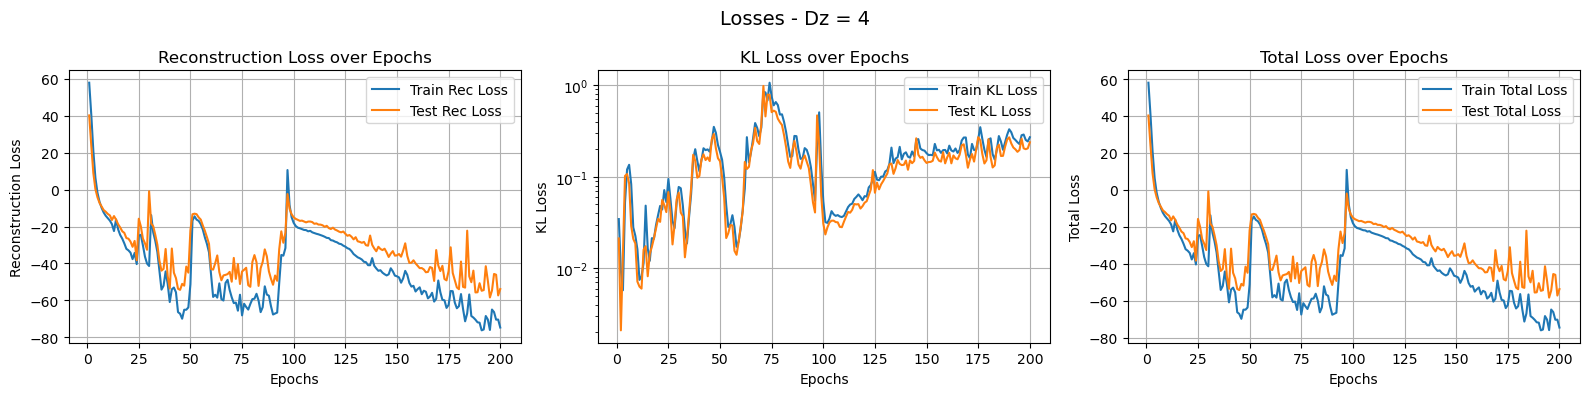

In [34]:
# plot losses
fig, ax = plt.subplots(figsize=(16,4), nrows=1, ncols=3)
epochs = np.arange(1, n_epochs+1)

# reconstruction loss
ax[0].plot(epochs, train_rec_losses, label='Train Rec Loss')
ax[0].plot(epochs, test_rec_losses, label='Test Rec Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Reconstruction Loss')
ax[0].set_title('Reconstruction Loss over Epochs')
ax[0].legend()
ax[0].grid(True)
# KL loss
ax[1].plot(epochs, train_kl_losses, label='Train KL Loss')
ax[1].plot(epochs, test_kl_losses, label='Test KL Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('KL Loss')
ax[1].set_yscale('log')
ax[1].set_title('KL Loss over Epochs')
ax[1].legend()
ax[1].grid(True)
# total loss
ax[2].plot(epochs, train_total_losses, label='Train Total Loss')
ax[2].plot(epochs, test_total_losses, label='Test Total Loss')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Total Loss')
ax[2].set_title('Total Loss over Epochs')
ax[2].legend()
ax[2].grid(True)

fig.suptitle(f'Losses - Dz = {Dz}', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# load best model
checkpoint = torch.load(save_file, map_location=device)
rnn_encoder.load_state_dict(checkpoint['rnn_encoder_state_dict'])
latent_ode_func.load_state_dict(checkpoint['latent_ode_func_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1
train_loss = checkpoint['train_total_loss']
test_loss = checkpoint['test_total_loss']

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Reconstruction
</div>

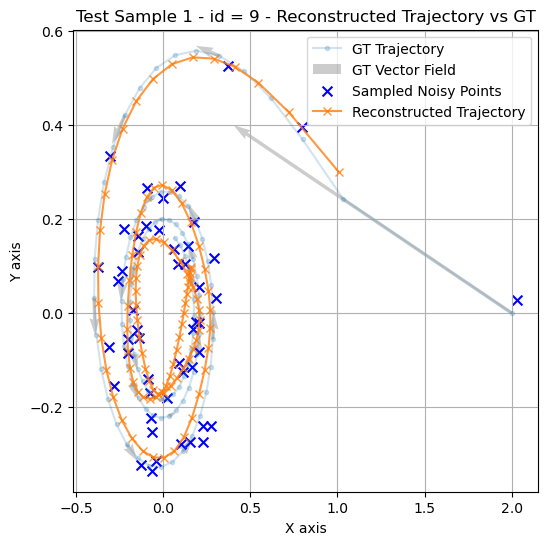

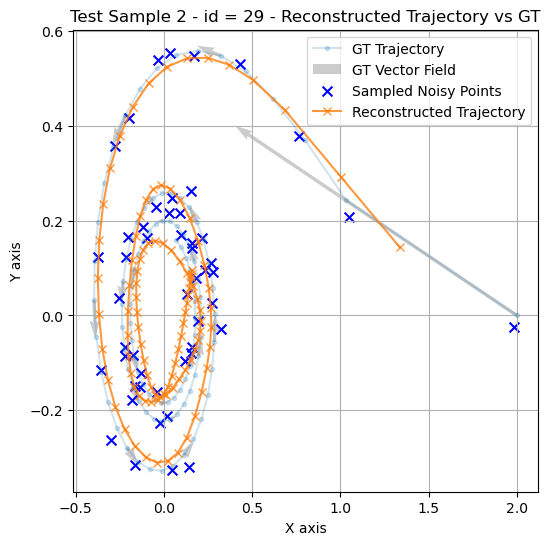

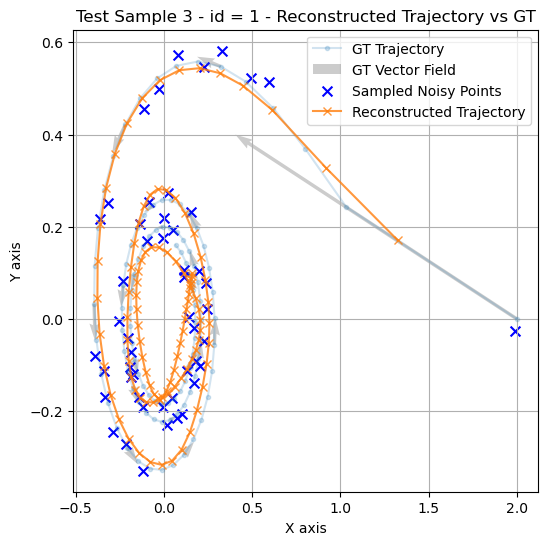

In [37]:
# number of samples we want to reconstruct and visualize
N_VIZ = 3

# get N_VIZ random indices in the test dataset
idx = np.random.choice(len(test_dataset), size=N_VIZ, replace=False)

# number of time steps for reconstruction
n_steps = 100
t_end = 20.0

for i, id in enumerate(idx):
    # get the spiral sample from the test dataset
    ts, xs, flows, ts_all, xs_all, flows_all = test_dataset[id]
    ts = ts.to(device)
    xs = xs.to(device)
    # print(ts[0], ts[-1])
    # print(xs[0], xs[-1])
    flows = flows.to(device)
    ts_all = ts_all.to(device)
    xs_all = xs_all.to(device)
    flows_all = flows_all.to(device)
    
    # reconstruct the trajectory with the trained model
    with torch.no_grad():
        # get the initial latent state z0 according to the learnt posterior q_phi(z0 | x0:N)
        z0_mean, z0_logvar = rnn_encoder(ts, xs)
        mu_phi = z0_mean.to(device)
        sigma_phi = torch.diag_embed(torch.exp(0.5 * z0_logvar).to(device))
        q_phi = MultivariateNormal(mu_phi, sigma_phi)
        # get 1 sample of z0 from q_phi
        # we could also use z0_mean directly
        z0_sample = q_phi.rsample().to(device).squeeze()
        # z0_sample = z0_mean.to(device)  # alternatively use the mean
        # print(z0_sample)
        # compute the latent trajectory z1:N from z0 and t1:N with latent ODE on ALL time steps from our t0 to t_end
        times = torch.linspace(ts[0], t_end, n_steps).to(device)
        z_sample = odeint_adjoint(latent_ode_func, z0_sample, times, rtol=1e-2, atol=1e-2, method='rk4')
        # decode the full latent trajectory to get p_theta(x | z)
        mu_x, logvar_x = decoder(z_sample.unsqueeze(0))
        sigma_x = torch.exp(0.5 * logvar_x).to(device)
        p_theta_x = Independent(Normal(mu_x, sigma_x),1)
        # get the mean trajectory
        x_recon = mu_x.squeeze(0)
        # print(x_recon[0], x_recon[-1])
    
    # plot the reconstructed trajectory against the ground truth
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(xs_all[:,0].detach().cpu().numpy(), xs_all[:,1].detach().cpu().numpy(), label='GT Trajectory', alpha=0.2, marker='.')
    ax.quiver(xs_all[::5,0].detach().cpu().numpy(), xs_all[::5,1].detach().cpu().numpy(), 
                flows_all[::5,0].detach().cpu().numpy(), flows_all[::5,1].detach().cpu().numpy(), 
                angles='xy', scale_units='xy', scale=5.0, alpha=0.2, label='GT Vector Field')
    ax.scatter(xs[:,0].detach().cpu().numpy(), xs[:,1].detach().cpu().numpy(), color='b', marker='x', s=50.0, label='Sampled Noisy Points')
    ax.plot(x_recon[:,0].detach().cpu().numpy(), x_recon[:,1].detach().cpu().numpy(), marker='x', label='Reconstructed Trajectory', alpha=0.8)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_title(f"Test Sample {i+1} - id = {id} - Reconstructed Trajectory vs GT")
    ax.legend()
    ax.grid(True)

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Génération
</div>

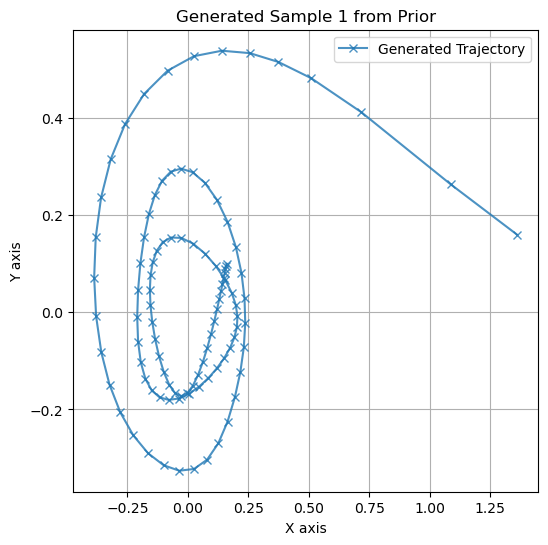

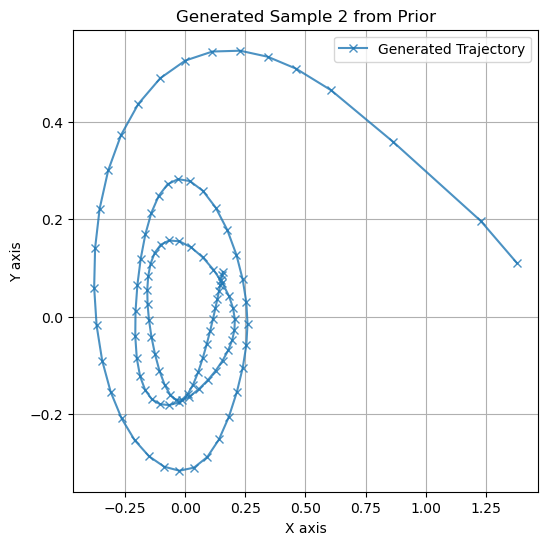

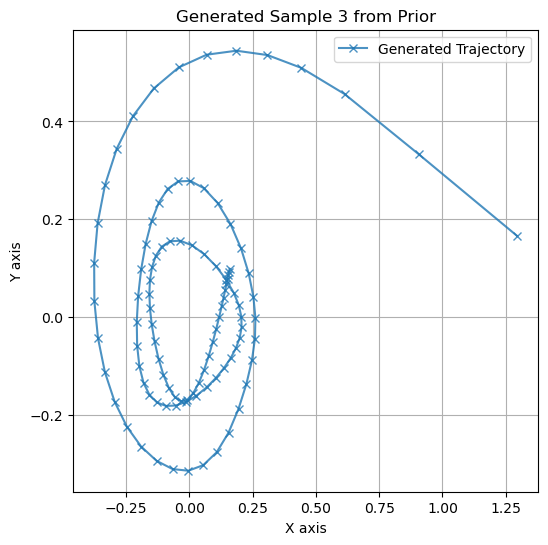

In [38]:
# number of trajectories to generate
N_GEN = 3

for i in range(N_GEN):
    # sample prior z0 ~ p(z0)
    z0_sample = p_theta_z.sample().to(device)
    # compute the latent trajectory z1:N from z0 and t1:N with latent ODE on ALL time steps from our t0 to t_end
    times = torch.linspace(t_start, t_end, n_steps).to(device)
    z_sample = odeint_adjoint(latent_ode_func, z0_sample, times,rtol=1e-2, atol=1e-2, method='rk4')
    # decode the full latent trajectory to get p_theta(x | z)
    mu_x, logvar_x = decoder(z_sample.unsqueeze(0))
    sigma_x = torch.exp(0.5 * logvar_x).to(device)
    p_theta_x = Independent(Normal(mu_x, sigma_x),1)
    # get the mean trajectory
    x_gen = mu_x.squeeze(0)
    
    # plot the generated trajectory
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(x_gen[:,0].detach().cpu().numpy(), x_gen[:,1].detach().cpu().numpy(), marker='x', label='Generated Trajectory', alpha=0.8)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_title(f"Generated Sample {i+1} from Prior")
    ax.legend()
    ax.grid(True)
    plt.show()
    